In [5]:
import tensorflow as tf
import numpy as np

#Imports for visualization
from matplotlib import cm
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [37]:

def DisplayArray(a, fmt='png', val_range=[0,1], width=400):
    """Display an array as a picture."""
    a = (a - val_range[0])/float(val_range[1] - val_range[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    img = PIL.Image.fromarray(cm.viridis(a, bytes=True))
    
    basewidth = width
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), PIL.Image.NEAREST) # PIL.Image.LANCZOS)
    
    #img.save(f, fmt)
    clear_output(wait = True)
    display(img)
    #display(Image(data=f.getvalue()))

In [15]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def simple_conv_periodic(x, k):
    """A simplified 2D convolution operation, with periodic boundaries"""
    x_shape = tf.shape(x)
    a = tf.tile(x, [3, 3]) # copy image into a 3x3 
    x = a[x_shape[0]-2:x_shape[0]*2+2, x_shape[1]-2:x_shape[1]*2+2] # cut out relevant part in the middle
    
    x = tf.expand_dims(tf.expand_dims(x, 0), -1) # add dimensions for batch_size and channels 
    #y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='VALID')
    y = tf.nn.conv2d(x, k, [1, 1, 1, 1], padding='VALID')
    print(tf.shape(y))
    return y[0, 1:-1, 1:-1, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv_periodic(x, laplace_k)

In [45]:
N = 200

# Set everything to zero
#v_init = np.random.normal(loc=0.5, scale=0.1, size=[N,N])
v_init = np.zeros([N, N])
v_init[ 0 : int(N/4), int(N/2)-10 : int(N/2)+10 ] = 1
v_init = np.array(v_init, dtype=np.float32)

w_init = np.zeros([N, N], dtype=np.float32)
w_init[ 0 : int(N/4), int(N/2)+0 : int(N/2)+20 ] = 1
#w_init[0:25,50:65] = 1
w_init = np.array(w_init, dtype=np.float32)


In [46]:
# Create variables for simulation state
V = tf.Variable(v_init)
W = tf.Variable(w_init)

# Parameters
dt    = tf.placeholder(tf.float32, shape=())
alpha = tf.placeholder(tf.float32, shape=())
eps   = tf.placeholder(tf.float32, shape=())
gamma = tf.placeholder(tf.float32, shape=())
alpha_v = tf.placeholder(tf.float32, shape=())
#alpha_w = tf.placeholder(tf.float32, shape=())

p_alpha = 0.139
p_eps   = 0.008
p_gamma = 6.5#5.5

stoptime = 25000
ddt = 0.25
dx = 1.0
Dv = 0.5
#Dw =5.0
alphav = np.float32((Dv * ddt) / (dx*dx))
#alphaw = np.float32((Dw * ddt) / (dx*dx))
print(alphav)

0.125


In [50]:
with tf.name_scope('PDE_model'):
    # Discretized PDE update rules
    V_ = V + dt * (alpha_v*laplace(V) + V*(V-alpha)*(1-V)-W)
    W_ = W + dt * (eps*(V-gamma*W))


Tensor("PDE_model/Shape_1:0", shape=(4,), dtype=int32)


In [52]:
with tf.name_scope('Step'):
    # Operation to update the state
    step = tf.group(
      V.assign(V_),
      W.assign(W_)
    )
    
with tf.name_scope('Check'):
    # Check for NaNs and Infs
    check = tf.group(
      tf.check_numerics(V, message='Error: NaNs of Infs in V'),
      tf.check_numerics(W, message='Error: NaNs of Infs in W')
    )


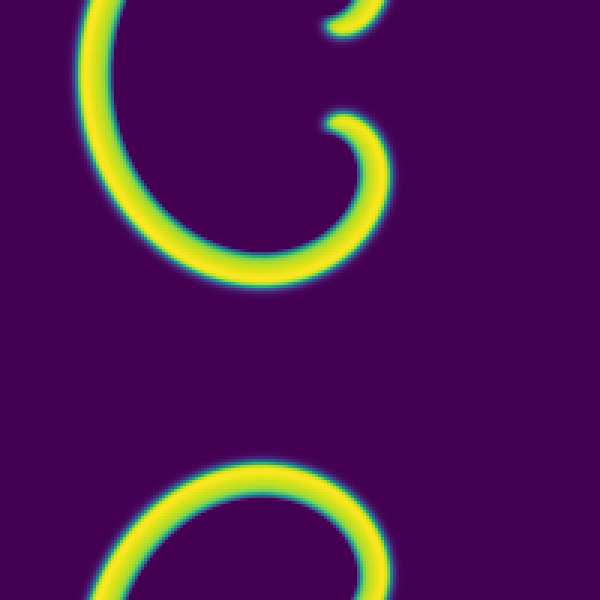

KeyboardInterrupt: 

In [53]:
# Using the context manager.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(stoptime):

        sess.run(step, feed_dict={
                dt     : ddt,
                alpha  : p_alpha,
                eps    : p_eps,
                gamma  : p_gamma,
                alpha_v: alphav})
        
        if i % 100 == 0:
            sess.run(check)
            
        if i % 250 == 0:
            arr = V.eval()
            DisplayArray(V.eval(), val_range=[0.0, np.amax(arr)], width=600)
